In [1]:
import os

import sys
sys.path.append('..')

import toml
from tqdm import tqdm

import matplotlib.pyplot as plt

import statsmodels.api as sm

import torch
import numpy as np

from models.vision_transformer import ViT
from data.datasets import TimeSeriesDataset
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
config_path = '/glade/u/home/jshen/pruning-turbulence-vit/src/config/prune/taylor.toml'
config = toml.load(config_path)

config['checkpoint_file'] = '/glade/derecho/scratch/jshen/base/best.tar'

In [3]:
model = ViT(**config['model']).to(device)
state_dict = torch.load(config['checkpoint_file'], map_location=device, weights_only=False)
model.load_state_dict(state_dict)
model.eval()

dataset = TimeSeriesDataset(**config['train_dataset'])

## Magnitude

In [4]:
l1_scores = torch.concat([
    getattr(m, name).flatten().abs()
    for (m, name) in model.get_weights()
]).detach().cpu().numpy()

## Taylor

In [5]:
def taylor_scores(batch_size=1, num_samples=2048):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    exact_scores_dict = {
        (m, name): torch.zeros_like(getattr(m, name), requires_grad=False, device='cpu')
        for (m, name) in model.get_weights()
    }

    for i, (x, y_true) in tqdm(enumerate(dataloader)):
        if i >= num_samples // batch_size: break
        x, y_true = x.to(device), y_true.to(device)

        model.zero_grad(set_to_none=True)
        y_pred = model(x)
        err = (y_pred - y_true).pow(2)
        loss = err.flatten(1).mean(1).sum()
        loss.backward()

        with torch.no_grad():
            for (m, name) in model.get_weights():
                param = getattr(m, name)
                if param.grad is not None:
                    update = (param.grad * param).detach().pow(2).cpu()
                    exact_scores_dict[(m, name)].add_(update)

    for k in exact_scores_dict:
        exact_scores_dict[k].div_(float(i))

    return torch.concat([t.flatten() for t in exact_scores_dict.values()]).detach().cpu().numpy()

2048it [02:33, 13.36it/s]
4it [00:00, 17.78it/s]


Number of samples: 4
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                 1.522e+06
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:23:11   Log-Likelihood:             5.9345e+07
No. Observations:             2230272   AIC:                        -1.187e+08
Df Residuals:                 2230270   BIC:                        -1.187e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.818e-14   4.53e-1

8it [00:00, 16.98it/s]


Number of samples: 8
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                 2.454e+06
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:23:12   Log-Likelihood:             5.9593e+07
No. Observations:             2230272   AIC:                        -1.192e+08
Df Residuals:                 2230270   BIC:                        -1.192e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.052e-14   4.06e-1

32it [00:01, 18.90it/s]


Number of samples: 32
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 8.085e+06
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:23:14   Log-Likelihood:             6.0473e+07
No. Observations:             2230272   AIC:                        -1.209e+08
Df Residuals:                 2230270   BIC:                        -1.209e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.375e-14   2.75e-

128it [00:06, 18.93it/s]


Number of samples: 128
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.994e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:23:21   Log-Likelihood:             6.1741e+07
No. Observations:             2230272   AIC:                        -1.235e+08
Df Residuals:                 2230270   BIC:                        -1.235e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.744e-15   1.56e

512it [00:26, 19.04it/s]


Number of samples: 512
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.337e+08
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:             6.3348e+07
No. Observations:             2230272   AIC:                        -1.267e+08
Df Residuals:                 2230270   BIC:                        -1.267e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.169e-15   7.58e

1024it [00:53, 19.10it/s]


Number of samples: 1024
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.899e+08
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:24:42   Log-Likelihood:             6.4530e+07
No. Observations:             2230272   AIC:                        -1.291e+08
Df Residuals:                 2230270   BIC:                        -1.291e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.591e-16   4.46

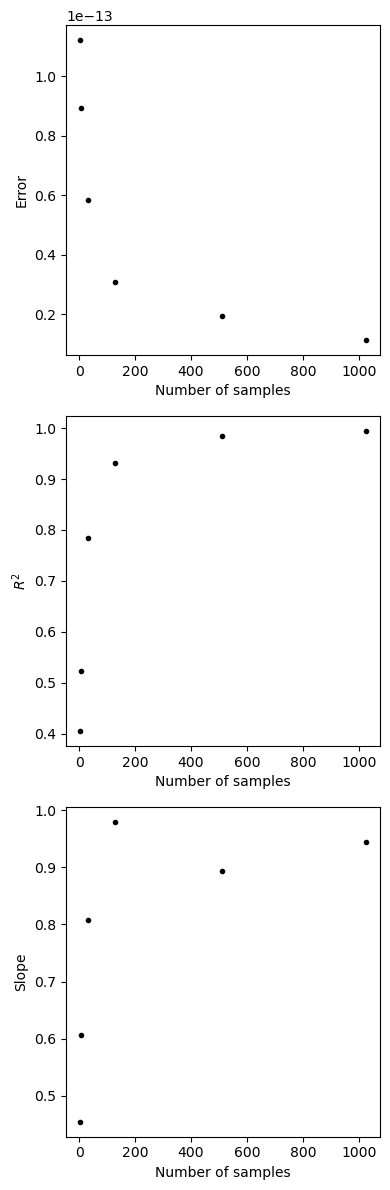

In [6]:
nums_samples = [4, 8, 32, 128, 512, 1024]

best_scores = taylor_scores(1, 2048)

r2_scores = []
slopes = []
errors = []
for num_samples in nums_samples:
    exact_scores = taylor_scores(1, num_samples)
    errors.append(np.abs(exact_scores - best_scores).mean())
    
    reg = sm.OLS(best_scores, sm.add_constant(exact_scores)).fit()
    r2_scores.append(reg.rsquared)
    slopes.append(reg.params[1])

    print(f'Number of samples: {num_samples}')
    print(reg.summary())

print(errors)
print(r2_scores)
print(slopes)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(4, 12))

ax0.plot(nums_samples, errors, 'k.')
ax0.set_xlabel('Number of samples')
ax0.set_ylabel('Error')

ax1.plot(nums_samples, r2_scores, 'k.')
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('$R^2$')

ax2.plot(nums_samples, slopes, 'k.')
ax2.set_xlabel('Number of samples')
ax2.set_ylabel('Slope')

fig.tight_layout()

## Approximate Taylor

4096it [04:19, 15.78it/s]


Batch size: 1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.001e+08
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:29:03   Log-Likelihood:             6.5459e+07
No. Observations:             2230272   AIC:                        -1.309e+08
Df Residuals:                 2230270   BIC:                        -1.309e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.227e-16   2.94e-17    -1

2048it [01:46, 19.16it/s]


Batch size: 2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.858e+19
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:30:51   Log-Likelihood:             9.3802e+07
No. Observations:             2230272   AIC:                        -1.876e+08
Df Residuals:                 2230270   BIC:                        -1.876e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.799e-22    8.9e-23     -

1024it [00:52, 19.33it/s]


Batch size: 4
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.899e+08
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:31:44   Log-Likelihood:             6.4530e+07
No. Observations:             2230272   AIC:                        -1.291e+08
Df Residuals:                 2230270   BIC:                        -1.291e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.591e-16   4.46e-17     1

512it [00:26, 19.34it/s]


Batch size: 8
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.337e+08
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:11   Log-Likelihood:             6.3348e+07
No. Observations:             2230272   AIC:                        -1.267e+08
Df Residuals:                 2230270   BIC:                        -1.267e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.169e-15   7.58e-17     2

256it [00:13, 19.33it/s]


Batch size: 16
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 6.651e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:25   Log-Likelihood:             6.2588e+07
No. Observations:             2230272   AIC:                        -1.252e+08
Df Residuals:                 2230270   BIC:                        -1.252e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.909e-15   1.07e-16     

128it [00:06, 19.30it/s]


Batch size: 32
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.994e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:32   Log-Likelihood:             6.1741e+07
No. Observations:             2230272   AIC:                        -1.235e+08
Df Residuals:                 2230270   BIC:                        -1.235e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.744e-15   1.56e-16     

85it [00:04, 19.28it/s]


Batch size: 48
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 1.861e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:37   Log-Likelihood:             6.1257e+07
No. Observations:             2230272   AIC:                        -1.225e+08
Df Residuals:                 2230270   BIC:                        -1.225e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.076e-14   1.94e-16     

64it [00:03, 19.22it/s]


Batch size: 64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.532e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:40   Log-Likelihood:             6.1066e+07
No. Observations:             2230272   AIC:                        -1.221e+08
Df Residuals:                 2230270   BIC:                        -1.221e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.127e-14   2.11e-16     

51it [00:02, 19.24it/s]


Batch size: 80
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.282e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:43   Log-Likelihood:             6.0894e+07
No. Observations:             2230272   AIC:                        -1.218e+08
Df Residuals:                 2230270   BIC:                        -1.218e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.415e-14   2.28e-16     

42it [00:02, 19.18it/s]


Batch size: 96
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 1.055e+07
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:46   Log-Likelihood:             6.0712e+07
No. Observations:             2230272   AIC:                        -1.214e+08
Df Residuals:                 2230270   BIC:                        -1.214e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.667e-14   2.47e-16     

32it [00:01, 19.15it/s]


Batch size: 128
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 8.085e+06
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:32:48   Log-Likelihood:             6.0473e+07
No. Observations:             2230272   AIC:                        -1.209e+08
Df Residuals:                 2230270   BIC:                        -1.209e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.375e-14   2.75e-16    

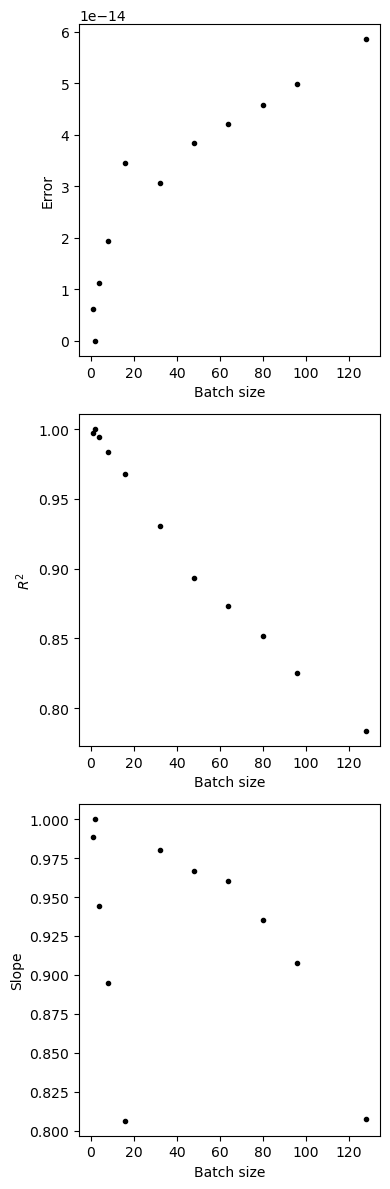

In [7]:
batch_sizes = [1, 2, 4, 8, 16, 32, 48, 64, 80, 96, 128]

r2_scores = []
slopes = []
errors = []
for batch_size in batch_sizes:

    scores = taylor_scores(batch_size, 4096)

    reg = sm.OLS(best_scores, sm.add_constant(scores)).fit()

    r2_scores.append(reg.rsquared)
    slopes.append(reg.params[1])
    errors.append(np.abs(best_scores - scores).mean())

    print(f'Batch size: {batch_size}')
    print(reg.summary())

print(errors)
print(r2_scores)
print(slopes)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(4, 12))

ax0.plot(batch_sizes, errors, 'k.')
ax0.set_xlabel('Batch size')
ax0.set_ylabel('Error')

ax1.plot(batch_sizes, r2_scores, 'k.')
ax1.set_xlabel('Batch size')
ax1.set_ylabel('$R^2$')

ax2.plot(batch_sizes, slopes, 'k.')
ax2.set_xlabel('Batch size')
ax2.set_ylabel('Slope')

fig.tight_layout()